In [1]:
from elasticsearch import Elasticsearch
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from algorithm.co_occ import BFSConstructor, CoNetwork
from algorithm.const import *
from algorithm.adapter import NetworkXAdapter, nx_draw_network

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 设置中文字体，并保证负号正常显示

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


In [2]:
es = Elasticsearch("http://127.0.0.1:9204", request_timeout=60)
dict(es.info())

{'name': 'node0',
 'cluster_name': 'docbase',
 'cluster_uuid': '63TQlJkjRvyY3NtujxmYuQ',
 'version': {'number': '8.6.1',
  'build_flavor': 'default',
  'build_type': 'zip',
  'build_hash': '180c9830da956993e59e2cd70eb32b5e383ea42c',
  'build_date': '2023-01-24T21:35:11.506992272Z',
  'build_snapshot': False,
  'lucene_version': '9.4.2',
  'minimum_wire_compatibility_version': '7.17.0',
  'minimum_index_compatibility_version': '7.0.0'},
 'tagline': 'You Know, for Search'}

In [3]:
words_agg = {
    "top_words": {
        "terms": {
            "field": "content",
            "size": 200,
        }
    }
}
res = es.search(index=DEFAULT_INDEX, aggs=words_agg, size=0)

top_word_buckets_list = [
    bucket for bucket in
    res["aggregations"]["top_words"]["buckets"]
    if len(bucket["key"]) > 1
]

top_word_buckets_list[:5]


[{'key': '图书馆', 'doc_count': 667},
 {'key': '研究', 'doc_count': 465},
 {'key': '我国', 'doc_count': 445},
 {'key': '思考', 'doc_count': 341},
 {'key': '报道', 'doc_count': 333}]

C:\Users\jayde\AppData\Local\Temp\ipykernel_9328\2757433802.py:30: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=[item["doc_count"] for item in top_word_buckets_list],ax=sub_ax)
C:\Users\jayde\AppData\Local\Temp\ipykernel_9328\2757433802.py:34: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=[

Text(0, 0.5, '')

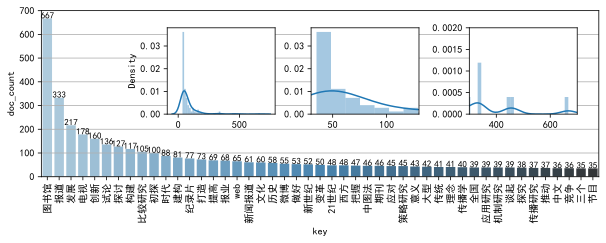

In [4]:
import matplotlib.pyplot as plt
top_word_sub_buckets = pd.DataFrame(
    bucket for i, bucket in
    enumerate( top_word_buckets_list ) 
    if i % 4 == 0
)
fig, ax = plt.subplots(figsize=(10, 3))
sns.barplot(
    data=top_word_sub_buckets, 
    x="key", y="doc_count",
    palette="Blues_d",
    ax=ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
)
for index,row in top_word_sub_buckets.iterrows():
#采用iterrows方法对这个dataframe进行遍历即可
    ax.text(
        index,row["doc_count"],
        row["doc_count"],
        ha="center",
        fontsize=9
        )
ax.grid(visible=True, axis="y")

pos = [0.3, 0.4, 0.15, 0.4]
sub_ax: plt.Axes = fig.add_axes(pos)
sns.distplot(a=[item["doc_count"] for item in top_word_buckets_list],ax=sub_ax)

pos = [0.5, 0.4, 0.15, 0.4]
sub_ax: plt.Axes = fig.add_axes(pos)
sns.distplot(a=[item["doc_count"] for item in top_word_buckets_list],ax=sub_ax)
sub_ax.set_xlim(30, 130)
sub_ax.set_ylabel("")

pos = [0.72, 0.4, 0.15, 0.4]
sub_ax: plt.Axes = fig.add_axes(pos)
sns.distplot(a=[item["doc_count"] for item in top_word_buckets_list],ax=sub_ax)
sub_ax.set_xlim(300, 700)
sub_ax.set_ylim(0, 0.002)
sub_ax.set_ylabel("")

In [5]:
queries = [
    {
        "bool": {
            "must": [
                {
                    "wildcard": {
                        DEFAULT_FIELD: f"*{bucket['key']}*"
                    },
                },
            ]
        }
    } for bucket in top_word_buckets_list
]

len(queries)

187

In [6]:
constructor = BFSConstructor(client=es)
constructor

0x1594343CD90 co_occ_test content

In [7]:
tests = [queries[8],queries[16],queries[30]]
print(tests)
networks = [
    constructor.get_network(query)
    for query in tests
]
print(networks)

[{'bool': {'must': [{'wildcard': {'content': '*发展*'}}]}}, {'bool': {'must': [{'wildcard': {'content': '*创新*'}}]}}, {'bool': {'must': [{'wildcard': {'content': '*网络*'}}]}}]
[nodes: 138, edges: 199, nodes: 142, edges: 248, nodes: 108, edges: 190]


In [8]:
adapted_ls = [
    NetworkXAdapter(network)
    for network in networks
]
print(adapted_ls)

[Adapter at 0x1594343CBE0, network nodes: 138, edges: 199, Adapter at 0x1593DD12D30, network nodes: 142, edges: 248, Adapter at 0x1593DD12CD0, network nodes: 108, edges: 190]


In [9]:
graphs = []
for network in adapted_ls:
    graph = nx.Graph()
    graph.add_nodes_from(network.nodes)
    graph.add_edges_from(network.edges)
    graphs.append(graph)
graphs

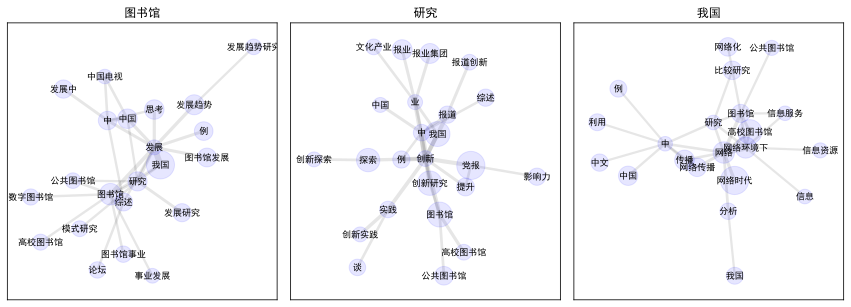

In [10]:
fig, axes = plt.subplots(1, len(graphs), figsize=(15, 5))
for i, ax in enumerate(axes):
    pos = nx.layout.spring_layout(graphs[i])
    nx_draw_network(graphs[i], pos, ax)
    ax.set_title(top_word_buckets_list[i]["key"])
fig.subplots_adjust(wspace=0.05)

说明 depth 可以视作一个常数

In [11]:
query = {
        "bool": {
            "must": [
                {
                    "wildcard": {
                        DEFAULT_FIELD: "*发展*"
                    },
                },
            ]
        }
    } 
constructors: list[BFSConstructor] = [
    BFSConstructor(client=es, depth=2),
    BFSConstructor(client=es, depth=5),
    BFSConstructor(client=es, depth=15),
]
colors = ["r", "g", "b"]
constructors

[0x159421DC5B0 co_occ_test content,
 0x15942295C10 co_occ_test content,
 0x15942295250 co_occ_test content]

In [12]:
graphs = []
networks = []
for limit in (30, 60):
    for c in constructors:
        network = c.get_network(query)
        a_net = NetworkXAdapter(network, limit)
        graph_ = nx.Graph()
        graph_.add_edges_from(a_net.edges)
        graph_.add_nodes_from(a_net.nodes)
        graphs.append(graph_)
        networks.append(a_net)

graphs

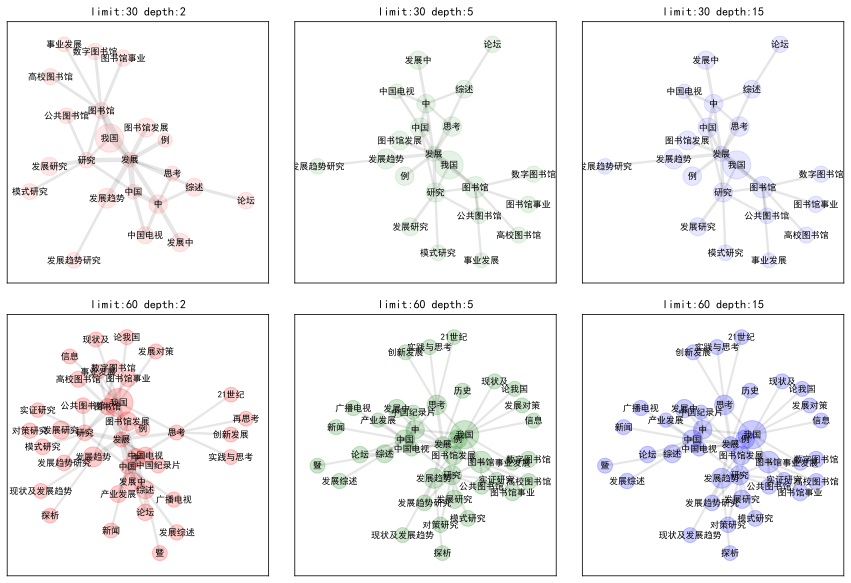

In [13]:
row_n = int(len(graphs)/2)
fig, axes = plt.subplots(2, row_n, figsize=(15, 10))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        g_index = i*row_n + j
        pos = nx.layout.spring_layout(graphs[g_index], seed=666)
        ax.set_title(f"limit:{networks[g_index].limit} depth:{constructors[g_index%3].depth}")
        alpha = 0.1 if i == 0 else 0.2
        nx_draw_network(graphs[g_index], pos, ax, node_color=colors[g_index%3], node_alpha=alpha)
fig.subplots_adjust(wspace=0.1)
fig.subplots_adjust(hspace=0.12)